### Jackknife for Parameter Inference

- A "leave-one-out" cross-validation technique.
- Works on IID data and estimators that are smooth functions of the data. 
- Works on a linear approximation of the finite sample bias, so does not do so well with Variances, R^2, etc.
- Developed by Quenouille to estimate bias of an estimator, expanded by Tukey for variance estimation.

### Process

1. Compute the parameter estimate using the full sample:
   - $ \hat{\theta} = f(X_1, X_2, \dots, X_N) $
2. Exclude each observation $ n $ and compute the partial estimate:
   - $ \hat{\theta}_{-n} = f(X_1, \dots, X_{n-1}, X_{n+1}, \dots, X_N) $
3. Calculate pseudo-values:
   - $ \theta^*_n = N \cdot \hat{\theta} - (N - 1) \cdot \hat{\theta}_{-n} $
4. Compute the jackknife estimate of the parameter:
   - $ \theta^* = \frac{1}{N} \sum_{n=1}^N \theta^*_n $
5. Estimate the standard error:
   - $ \sigma_{\theta^*} = \sqrt{\frac{\sum (\theta^*_n - \theta^*)^2}{N(N - 1)}} $
6. Use the standard error for hypothesis testing or confidence intervals:
   - $ \theta^* \pm t_{\alpha, \nu} \cdot \sigma_{\theta^*}, \quad \nu = N - 1 $

+-----------------+--------------+------------------------+----------------------+----------------+--------------------+--------------------+------------------+---------------------+-------------+-----------+
| Metric          |   True Value |   Full-Sample Estimate |   Jackknife Estimate |   Jackknife SE | Jackknife CI       |   Monte Carlo Mean |   Monte Carlo SE | Monte Carlo CI      | True Bias   | True SE   |
+=================+==============+========================+======================+================+====================+====================+==================+=====================+=============+===========+
| Sample Mean     |          100 |                99.2563 |              99.2563 |         0.3045 | (98.6581, 99.8546) |           100.007  |           0.3129 | (99.3932, 100.6199) | -           | -         |
+-----------------+--------------+------------------------+----------------------+----------------+--------------------+--------------------+------------------+----

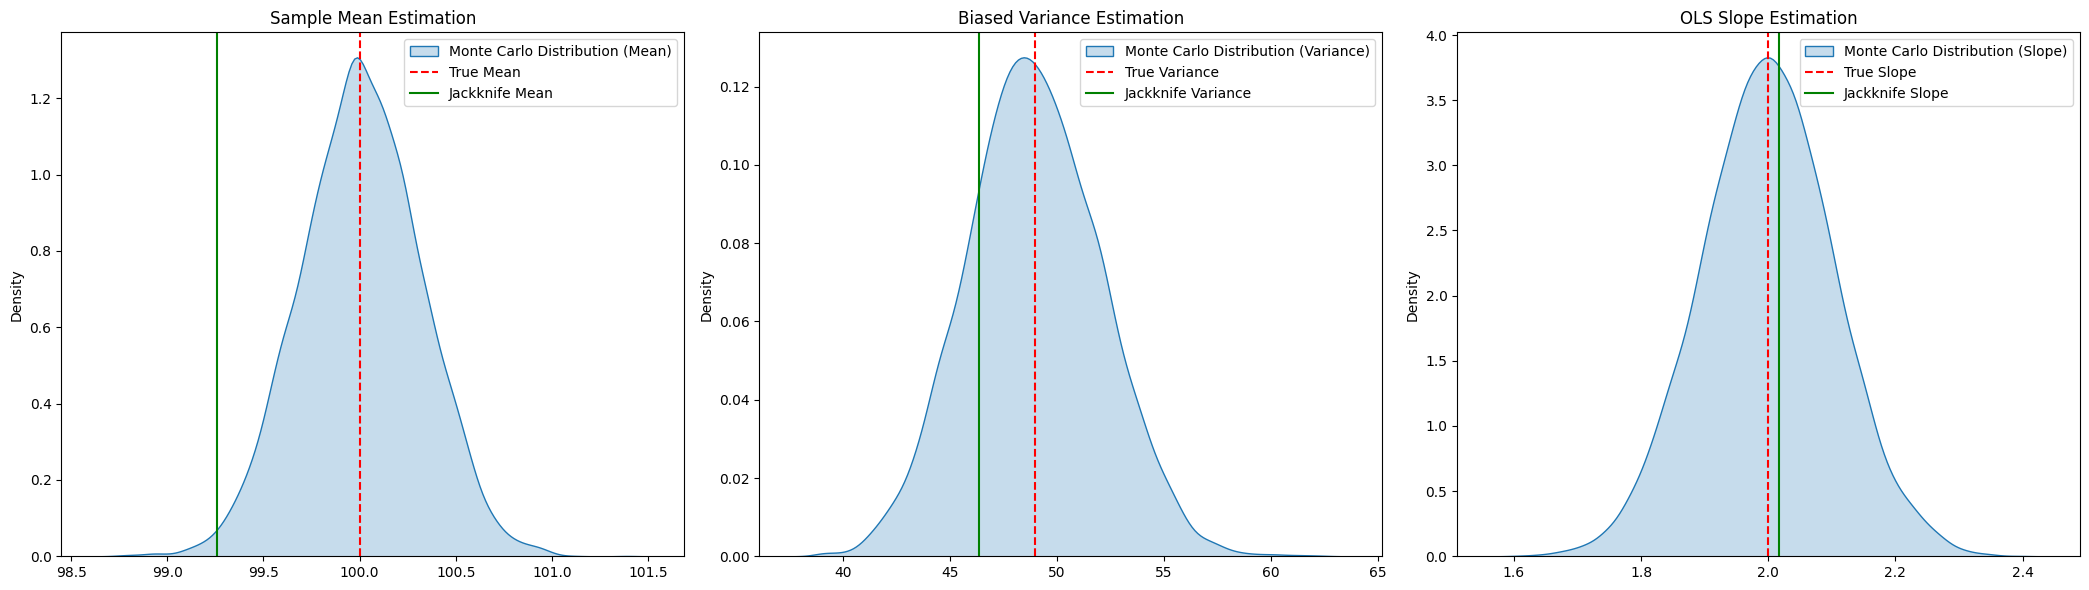

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t, skewnorm
from tabulate import tabulate

# Jackknife function
def jackknife(data, X=None, estimator_func=None):
    N = len(data)
    if X is None:  # Single variable case (e.g., variance, mean)
        full_sample_estimate = estimator_func(data)
        partial_estimates = np.zeros(N)
        for i in range(N):
            partial_data = np.delete(data, i)
            partial_estimates[i] = estimator_func(partial_data)
    else:  # Two variable case (e.g., OLS slope)
        full_sample_estimate = estimator_func(data, X)
        partial_estimates = np.zeros(N)
        for i in range(N):
            partial_Y = np.delete(data, i)
            partial_X = np.delete(X, i)
            partial_estimates[i] = estimator_func(partial_Y, partial_X)
    pseudo_values = N * full_sample_estimate - (N - 1) * partial_estimates
    jackknife_estimate = np.mean(pseudo_values)
    pseudo_value_variance = np.sum((pseudo_values - jackknife_estimate) ** 2) / (N * (N - 1))
    jackknife_se = np.sqrt(pseudo_value_variance)
    t_critical = t.ppf(1 - 0.025, df=N - 1)
    confidence_interval = (
        jackknife_estimate - t_critical * jackknife_se,
        jackknife_estimate + t_critical * jackknife_se
    )
    return full_sample_estimate, pseudo_values, jackknife_estimate, jackknife_se, confidence_interval

# Biased variance estimator function
def biased_variance(data):
    n = len(data)
    return np.sum((data - np.mean(data))**2) / n

# OLS Slope Estimator
def ols_slope(Y, X):
    return np.sum((X - np.mean(X)) * (Y - np.mean(Y))) / np.sum((X - np.mean(X)) ** 2)

# Biased Variance Analysis
np.random.seed(42)
true_mean = 100
true_std = 7
true_variance = true_std**2
sample_size = 500
true_bias = -true_variance / sample_size
true_se_variance = np.sqrt((2 * (sample_size - 1) * true_variance**2) / sample_size**2)

data = skewnorm.rvs(a=0, loc=true_mean, scale=true_std, size=sample_size)
fresh_mean_results = jackknife(data, estimator_func=np.mean)
fresh_var_results = jackknife(data, estimator_func=biased_variance)

num_trials = 10_000
monte_carlo_samples = [skewnorm.rvs(a=0, loc=true_mean, scale=true_std, size=sample_size) for _ in range(num_trials)]
mc_means = np.array([np.mean(sample) for sample in monte_carlo_samples])
mc_variances = np.array([biased_variance(sample) for sample in monte_carlo_samples])
mc_var = np.mean(mc_variances)
mc_var_se = np.std(mc_variances, ddof=1)
mc_var_ci = (mc_var - 1.96 * mc_var_se, mc_var + 1.96 * mc_var_se)

# OLS Slope Analysis
n = 100
true_intercept = 5
true_slope = 2
true_error_std = 3
X = np.random.uniform(0, 10, size=n)
errors = np.random.normal(0, true_error_std, size=n)
Y = true_intercept + true_slope * X + errors

full_sample_slope = ols_slope(Y, X)
slope_results = jackknife(Y, X, ols_slope)

mc_slopes = []
for _ in range(num_trials):
    mc_X = np.random.uniform(0, 10, size=n)
    mc_Y = true_intercept + true_slope * mc_X + np.random.normal(0, true_error_std, size=n)
    mc_slopes.append(ols_slope(mc_Y, mc_X))

mc_slopes = np.array(mc_slopes)
mc_mean_slope = np.mean(mc_slopes)
mc_se_slope = np.std(mc_slopes, ddof=1)
mc_ci_slope = (mc_mean_slope - 1.96 * mc_se_slope, mc_mean_slope + 1.96 * mc_se_slope)

true_se_slope = np.sqrt((true_error_std**2) / np.sum((X - np.mean(X))**2))

# Results Table
results_table = [
    ["Metric", "True Value", "Full-Sample Estimate", "Jackknife Estimate",
     "Jackknife SE", "Jackknife CI", "Monte Carlo Mean", "Monte Carlo SE", "Monte Carlo CI", "True Bias", "True SE"],
    ["Sample Mean", f"{true_mean:.4f}", f"{fresh_mean_results[0]:.4f}", f"{fresh_mean_results[2]:.4f}",
     f"{fresh_mean_results[3]:.4f}", f"({fresh_mean_results[4][0]:.4f}, {fresh_mean_results[4][1]:.4f})",
     f"{np.mean(mc_means):.4f}", f"{np.std(mc_means, ddof=1):.4f}",
     f"({np.mean(mc_means) - 1.96 * np.std(mc_means, ddof=1):.4f}, {np.mean(mc_means) + 1.96 * np.std(mc_means, ddof=1):.4f})", "-", "-"],
    ["Biased Variance", f"{true_variance:.4f}", f"{fresh_var_results[0]:.4f}", f"{fresh_var_results[2]:.4f}",
     f"{fresh_var_results[3]:.4f}", f"({fresh_var_results[4][0]:.4f}, {fresh_var_results[4][1]:.4f})",
     f"{mc_var:.4f}", f"{mc_var_se:.4f}", f"({mc_var_ci[0]:.4f}, {mc_var_ci[1]:.4f})", f"{true_bias:.4f}", f"{true_se_variance:.4f}"],
    ["OLS Slope", f"{true_slope:.4f}", f"{full_sample_slope:.4f}", f"{slope_results[2]:.4f}",
     f"{slope_results[3]:.4f}", f"({slope_results[4][0]:.4f}, {slope_results[4][1]:.4f})",
     f"{mc_mean_slope:.4f}", f"{mc_se_slope:.4f}", f"({mc_ci_slope[0]:.4f}, {mc_ci_slope[1]:.4f})", "-", f"{true_se_slope:.4f}"]
]

# Print the table
print(tabulate(results_table, headers="firstrow", tablefmt="grid"))

# Plotting
plt.figure(figsize=(21, 6))

# KDE for Sample Mean
plt.subplot(1, 3, 1)
sns.kdeplot(mc_means, label="Monte Carlo Distribution (Mean)", fill=True)
plt.axvline(true_mean, color="red", linestyle="--", label="True Mean")
plt.axvline(fresh_mean_results[2], color="green", linestyle="-", label="Jackknife Mean")
plt.title("Sample Mean Estimation")
plt.legend()

# KDE for Biased Variance
plt.subplot(1, 3, 2)
sns.kdeplot(mc_variances, label="Monte Carlo Distribution (Variance)", fill=True)
plt.axvline(true_variance, color="red", linestyle="--", label="True Variance")
plt.axvline(fresh_var_results[2], color="green", linestyle="-", label="Jackknife Variance")
plt.title("Biased Variance Estimation")
plt.legend()

# KDE for OLS Slope
plt.subplot(1, 3, 3)
sns.kdeplot(mc_slopes, label="Monte Carlo Distribution (Slope)", fill=True)
plt.axvline(true_slope, color="red", linestyle="--", label="True Slope")
plt.axvline(slope_results[2], color="green", linestyle="-", label="Jackknife Slope")
plt.title("OLS Slope Estimation")
plt.legend()

plt.tight_layout()
plt.show()

### Jackknife for Prediction Inference

- A leave-one-out method for evaluating predictive model performance.
- Provides unbiased estimates of generalization accuracy for IID data.
- Detects overfitting in high-dimensional or small-sample models.
- Advantages: Unbiased generalization metrics, highlights overfitting if $\text{MSE}_{\text{jack}} > \text{MSE}_{\text{train}}$. 
- Disadvatages: Computationally expensive ($N$ model fits), only works on IID data

### Process

1. Train the model on the full sample: $f(X, Y)$.
2. Exclude observation $n$, train on $N-1$, and predict $Y_n$: 
   $ \hat{Y}_{\text{jack}, n} = f_{-n}(X_n)$.
3. Repeat for all $n$ to obtain jackknife predictions: 
   $\hat{Y}_{\text{jack}} = [\hat{Y}_{\text{jack}, 1}, \dots, \hat{Y}_{\text{jack}, N}]$.
4. Compute metrics:
   - MSE: $\text{MSE}_{\text{jack}} = \frac{1}{N} \sum_{n=1}^N (Y_n - \hat{Y}_{\text{jack}, n})^2$.
   - $R^2$: $R^2_{\text{jack}} = 1 - \frac{\sum (Y_n - \hat{Y}_{\text{jack}, n})^2}{\sum (Y_n - \bar{Y})^2}$.
   - Bias: $\text{Bias}_{\text{jack}} = \frac{1}{N} \sum (\hat{Y}_{\text{jack}, n} - Y_n)$.

In [2]:
import numpy as np
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tabulate import tabulate

# Generate Data
def generate_data(n=100, dgp="linear", noise_std=1.0, seed=42):
    np.random.seed(seed)
    X = np.random.uniform(-3, 3, size=(n, 1))
    if dgp == "linear":
        Y = 2.0 * X[:, 0] + 1.0 + np.random.normal(0, noise_std, n)
    else:  # nonlinear
        Y = 2.0 * np.sin(X[:, 0]) + np.random.normal(0, noise_std, n)
    return X, Y

# Leave-One-Out Predictions
def leave_one_out_preds(X, Y, model_builder):
    N = len(Y)
    preds = np.zeros(N)
    for i in range(N):
        X_train = np.delete(X, i, axis=0)
        Y_train = np.delete(Y, i)
        model = model_builder()
        model.fit(X_train, Y_train)
        preds[i] = model.predict(X[i].reshape(1, -1))[0]
    return preds

# Metrics
def get_metrics(Y, Yhat):
    mse = mean_squared_error(Y, Yhat)
    r2 = r2_score(Y, Yhat)
    bias = np.mean(Yhat - Y)
    return mse, r2, bias

if __name__ == "__main__":
    n = 100
    results = []
    for dgp in ["linear", "nonlinear"]:
        X, Y = generate_data(n=n, dgp=dgp)
        for model_name, model_builder in [
            ("LinearReg",  lambda: LinearRegression()),
            ("LightGBM",   lambda: lgb.LGBMRegressor(verbose=-1)),
            ("RandomForest", lambda: RandomForestRegressor(n_estimators=100, random_state=0))
        ]:
            # Full sample fit
            model = model_builder()
            model.fit(X, Y)
            preds_full = model.predict(X)
            mse_full, r2_full, _ = get_metrics(Y, preds_full)

            # Leave-One-Out
            preds_jack = leave_one_out_preds(X, Y, model_builder)
            mse_jack, r2_jack, bias_jack = get_metrics(Y, preds_jack)

            results.append([
                dgp,
                model_name,
                f"{mse_full:.3f}",
                f"{r2_full:.3f}",
                f"{mse_jack:.3f}",
                f"{r2_jack:.3f}",
                f"{bias_jack:.3f}",
            ])

    table = [["DGP", "Model", "MSE_Full", "R2_Full", "MSE_Jack", "R2_Jack", "Bias_Jack"]]
    table.extend(results)
    print(tabulate(table, headers="firstrow", tablefmt="grid"))

+-----------+--------------+------------+-----------+------------+-----------+-------------+
| DGP       | Model        |   MSE_Full |   R2_Full |   MSE_Jack |   R2_Jack |   Bias_Jack |
+===========+==============+============+===========+============+===========+=============+
| linear    | LinearReg    |      0.807 |     0.935 |      0.839 |     0.933 |      -0.002 |
+-----------+--------------+------------+-----------+------------+-----------+-------------+
| linear    | LightGBM     |      0.807 |     0.935 |      1.156 |     0.907 |      -0.037 |
+-----------+--------------+------------+-----------+------------+-----------+-------------+
| linear    | RandomForest |      0.158 |     0.987 |      1.131 |     0.909 |      -0.033 |
+-----------+--------------+------------+-----------+------------+-----------+-------------+
| nonlinear | LinearReg    |      1.58  |     0.424 |      1.649 |     0.399 |      -0.002 |
+-----------+--------------+------------+-----------+------------+----